In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabels.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/Label_Analysis.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBoolean.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominal.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinal.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumeric.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 255)
Label(s) Data rows: 13
Boolean(s) Data rows: 58
Ordinal(s) Data rows: 34
Nominal(s) Data rows: 115
Numeric(s) Data rows: 48


### User Function(s):

In [4]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data

### User Function(s)

In [5]:
def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=model.classes_)
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    BalAcc = (Recall + Spec) / 2

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    # Prec = TP / (TP + FP)
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    # F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    AvgPrec = metrics.average_precision_score(y,pred)
        
    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(y, pred, zero_division=0))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, BalAcc, Prec, F1Score, AvgPrec, roc_auc


def stratified_grid(model, parameters, X_train, y_train, nSplit=5, score = 'balanced_accuracy'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plotFeatureImportance(model, X, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()


def metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'BalancedAccuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, BalancedAccuracy, RecallSensitivity, F1, AveragePrecision, Precision, Specificity, AUC]

    return data


def metricsClassifier(model, X, y, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X, y, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data
    

def metricsRegression(Algorithm, Model, Desc, MAE, MSE, RMSE, MAPE, R2, AdjR2):
    """
    Pass Regression metrics and Model Information
    """
    # 
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'MeanAbsoluteError', 'MeanSquareError','RootMeanSquareError', 'MreanAbsolutePercentageError', 'RSquare','AdjustedRSquare'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, MAE, MSE, RMSE, MAPE, R2, AdjR2]

    return data

In [6]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount
PrimaryPaymentSourceAfter_CAN,0.309639,46


#### Copy DataFrame

In [9]:
# deep copy
df_copy = df.copy()

In [10]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [11]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('GraftFailed_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric)

Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'LastFollowupNumber_CAN', 'TransplantStatus_CAN', 'TransplantSurvivalDay_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 255
Total rows after: 14,856 & columns: 243


In [12]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")
print("\nTotal Length of Features:", len(df_bool) + len(df_ordinal) + len(df_nominal) + len(df_numeric))

Orginal Data file Shape: (14856, 243)
Boolean(s) Data rows: 57
Ordinal(s) Data rows: 34
Nominal(s) Data rows: 106
Numeric(s) Data rows: 46

Total Length of Features: 243


In [13]:
# display all the features
print(sorted(df.columns.to_list()))

['AgeCalc_DON', 'Age_CAN', 'Age_difference', 'AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN', 'AntigenHLAcompatibility_A1', 'AntigenHLAcompatibility_A2', 'AntigenHLAcompatibility_B1', 'AntigenHLAcompatibility_B2', 'AntigenHLAcompatibility_DR1', 'AntigenHLAcompatibility_DR2', 'AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHistocompatibility_DA1_DON', 'AntigenHistocompatibility_DA2_DON', 'AntigenHistocompatibility_DR1_DON', 'AntigenHistocompatibility_DR2_DON', 'Antihypertensive_DON', 'ArginnieManagement_DON', 'AtTransplantSurfaceHBVAntibodyTotal_CAN', 'BMI_CAN', 'BMI_DON', 'BMI_difference', 'Biopsy_DON', 'BloodGroupMatchLevel', 'BloodGroup_CAN', 'BloodGroup_DON', 'BloodGroup_difference', 'BloodInfectionSource_DON', 'BloodPH_DON', 'Bl

#### Encode

In [14]:
df[df_nominal.nominal.to_list()].head()

,PriorCardiacSurgery_CAN,CocaineUse_DON,UrinePortein_DON,OtherDrugUse_DON,MyocardialInfarction_DON,Thyroxine_T4_DON,HeavyAlcoholUse_DON,OtherInfectionSource_DON,DialysisPrior_CAN,SerologyAntiCMV_DON,SteroidsUse_DON,PanelReactiveAntibody_CPRA_CAN,LifeSupport_CAN,CauseOfDeath_DON,EpsteinBarrStatusTransplant_CAN,DefibrillatorImplant_CAN,Hepatitis_B_CoreAntibody_DON,Antihypertensive_DON,Antibody_HEP_C_DON,SkinCancer_DON,PastCocaineUse_DON,Cancer_DON,EpsteinBarr_IGG_DON,CrossMatch,ChestXray_DON,PrimaryPaymentSourceAfter_CAN,Diuretics_DON,CardiacArrest_DON,FunctionalStatusAfter_CAN,WorkIncomeAfter_CAN,ArginnieManagement_DON,ResidencyStateAfter_CAN,WorkIncome_CAN,IntropesVasodilatorsAfter_CO_CAN,AtTransplantSurfaceHBVAntibodyTotal_CAN,IntropesVasodilators_CO_CAN,ResultHCV_NAT_DON,InsulinManagement_DON,IntropesVasodilatorsAfter_MN_CAN,WaitListDiagnosisCode_CAN,BloodGroup_CAN,Diabetes_CAN,PrimaryDiagnosisCode_CAN,ClinicalInfection_DON,PreviousMalignancy_CAN,ExtracanialCancer_DON,Hepatitis_B_CoreAntibody_CAN,CigaretteUse_CAN,GraftFailed_CAN,CigaretteHistory_DON,ResultHBVAfter_NAT_CAN,IntropesVasodilatorsAfter_DIA_CAN,DeathMechanism_DON,EpsteinBarr_IGM_DON,CMVStatusAtTransplant_CAN,SurfaceAntigenHEP_B_DON,BronchoscopyRight_DON,IntropesVasodilators_MN_CAN,BloodGroup_DON,Vasodilator_DON,Hypertension_DON,PriorLungSurgery_CAN,LV_EjectionFractionMedthod_DON,PastOtherDrugUse_DON,HeparinManagement_DON,AntibodyResultHBSAB_DON,InfectionTherapyIV_CAN,ResultHBV_NAT_DON,Biopsy_DON,SerostatusStatus_HEP_C_CAN,TransfusionNumber_DON,BronchoscopyLeft_DON,PriorCardiacSurgeryTypeAfter_CAN,IntropesVasodilatorsAfter_PCW_CAN,IntropesVasodilators_SYS_CAN,IntracanialCancer_DON,IntropesVasodilatorsAfter_SYS_CAN,PreTransplantResultHIV_NAT_CAN,SurfaceAntigenHEP_B_CAN,Transfusion_CAN,RiskHIV_DON,DialysisAfterList_CAN,TransplantSerostatusHIV_CAN,NonHeartBeating_DON,PulmCath_DON,ChronicSteroidsUse_CAN,DeceasedRetyped_DON,VentricularDeviceBrandAfter_CAN,CoronaryAngiogram_DON,HeartProcedureType_CAN,IntropesVasodilators_DIA_CAN,CerebrovascularDisease_CAN,PreTranspantHCV_NAT_CAN,PriorCardiacSurgeryAfter_CAN,Tatoos_DON,Result_RPR_VDRL_DON,LifeSupportAfter_CAN,HistoryCancer_DON,IntropesVasodilators_PCW_CAN,DiagnosisType_CAN,InotropicMedication_DON,Diabetes_DON,Triiodothyronine_T3_DON,VentricularDeviceTypeAfter_CAN,SynthicAntiDiureticHormone_DON,VentilatorySupportAfter_CAN
0,N,U,N,Y,N,N,N,0,N,Positive,Y,Low Sensitization,Y,HEAD TRAUMA,Positive,Y,Negative,N,Negative,N,N,No,Positive,Y,Abnormal,Free Care,Y,N,90% - Able to carry on normal activity: minor symptoms of disease,N,Y,NH,N,Y,Negative,N,Negative,N,Y,DILATED MYOPATHY,O,Yes,DILATED MYOPATHY,Y,N,N,Negative,Y,0,N,Unknown,Y,GUNSHOT WOUND,Negative,Positive,Negative,Abnormal,N,O,N,N,N,Echo,Y,Y,Unknown,N,Negative,Needle,Negative,NONE,Abnormal,"Other, specify",Y,N,N,Y,Unknown,Negative,Y,N,N,Negative,N,N,N,N,Heartware HVAD,Unknown,Orthotopic Bicaval,N,N,Unknown,Y,Y,Negative,Y,N,N,DILATED MYOPATHY,N,N,N,Lvad,N,Y
1,N,N,N,U,N,N,N,0,N,Positive,Y,Some Sensitization,Y,ANOXIA,Positive,Y,Negative,Y,Negative,N,Y,No,Positive,Y,Normal,Private insurance,Y,N,50% - Requires considerable assistance and frequent medical care,N,N,VA,N,N,Negative,N,Negative,Y,N,DILATED MYOPATHY,A,No,DILATED MYOPATHY,Y,N,N,Negative,N,1,N,Unknown,N,CARDIOVASCULAR,Negative,Positive,Negative,Normal,N,A1,Y,N,N,Echo,N,N,Unknown,Y,Negative,Needle,Negative,NONE,Normal,Unknown,N,N,N,N,Unknown,Negative,N,N,N,Negative,N,N,N,N,Heartmate II,Normal,Orthotopic Traditional,N,N,Unknown,N,Y,Negative,Y,N,N,DILATED MYOPATHY,N,Y,N,Lvad,N,N
2,Y,U,N,U,N,N,N,0,N,Positive,Y,Some Sensitization,Y,ANOXIA,Positive,Y,Negative,Y,Negative,N,N,No,Unknown,Y,Abnormal,Private insurance,Y,N,40% - Disabled: requires special care and assistance,Y,Y,IA,Y,N,Negative,N,Negative,Y,N,DILATED MYOPATHY,A,No,DILATED MYOPATHY,Y,N,N,Negative,N,0,N,Unknown,N,DRUG INTOXICATION,Unknown,Positive,Negative,Normal,N,O,Y,N,N,Echo,N,Y,Unknown,N,Negative,Needle,Negative,1 - 5,Normal,Unknown,N,N,N,N,Unknown,Negative,N,N,N

In [12]:
# display label
df.GraftFailed_CAN.value_counts(dropna=False)

GraftFailed_CAN
0    12956
1     1900
Name: count, dtype: int64

In [13]:
# features names to list
boolCol = df_bool.boolean.to_list()
nominalCol = df_nominal.nominal.to_list()
ordinalCol = df_ordinal.ordinal.to_list()
numericCol = df_numeric.numeric.to_list()

In [14]:
# encode columns
columns = df_nominal.nominal.to_list()

# remove label
columns.remove('GraftFailed_CAN')

# dummy Encoding
df_encoded = pd.get_dummies(df, columns=columns, drop_first=True)

#### Split Testing & Validation & Training

In [15]:
# split test and train
from sklearn.model_selection import train_test_split

# entire features
X = df_encoded.drop('GraftFailed_CAN', axis=1)
y = df_encoded['GraftFailed_CAN']

# split the dataset into 80% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# split train data into validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

### SMOTE

In [16]:
from imblearn.over_sampling import SMOTE

# initialize smote
smote = SMOTE(random_state=RANDOM_STATE)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Scale Data

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [18]:
# initialize StandardScaler
scaler = StandardScaler()

# fit
StandardScale = scaler.fit(X_train)

In [19]:
# transform
X_train_scaled = StandardScale.transform(X_train)
X_val_scaled = StandardScale.transform(X_val)
X_test_scaled = StandardScale.transform(X_test)


# convert the scaled data back into a DataFrame with the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# change datatype for FAMD
X_train_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_val_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_test_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')

In [20]:
X_train_scaled_df.shape

(8319, 317)

### Factor Analysis of Mixed Data (FAMD)

In [21]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [22]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_3 = prince.FAMD(n_components=317, n_iter=3, random_state=RANDOM_STATE).fit(X_train_scaled_df)
famd_5 = prince.FAMD(n_components=317, n_iter=5, random_state=RANDOM_STATE).fit(X_train_scaled_df)

# checking loading stability - get column contributions
famd_3_contributions = famd_3.column_contributions_
famd_5_contributions = famd_5.column_contributions_

# compare contributions between 3 iterations and 5 iterations
contribution_diff = famd_5_contributions - famd_3_contributions

In [23]:
# display
contribution_diff.head()

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PreviousTransplantNumber_CAN,-7.077672e-16,6.926968e-16,9.866240e-18,-3.773024e-17,1.951564e-18,2.291356e-19,-6.234162e-19,-3.035766e-18,-3.723471e-20,-2.324258e-18,2.422514e-19,-1.653408e-18,3.706616e-18,-5.109303e-18,1.727947e-18,-4.235165e-22,1.456897e-19,1.654255e-18,-1.223793e-17,4.767525e-18,2.846031e-18,1.607669e-18,4.206577e-19,6.140989e-21,-1.477225e-18,4.734914e-19,-3.049319e-19,-7.949404e-19,6.803792e-19,1.180023e-19,-1.228198e-20,-6.454391e-19,-3.934733e-19,-6.716971e-19,7.843525e-19,-1.555166e-19,-1.926576e-18,7.792703e-19,-1.007837e-19,3.381356e-18,7.318365e-19,1.541600e-18,-1.116389e-18,9.486769e-19,1.192622e-17,-9.141180e-18,-4.621412e-18,4.865145e-19,6.163488e-20,1.356411e-19,-8.555033e-20,-4.116580e-19,4.587530e-18,-1.829591e-19,3.030684e-18,-6.200281e-19,-4.096251e-18,-2.675830e-19,1.194316e-18,2.490277e-18,-2.486889e-18,8.870129e-18,-7.392904e-18,3.368941e-20,2.158240e-18,1.162129e-18,-1.482308e-20,1.221422e-18,-5.065257e-19,-1.694066e-20,4.038653e-18,-1.558541e-18,1.286537e-18,-1.334924e-18,4.143685e-18,-9.368184e-18,2.558040e-18,-4.503674e-18,-1.368805e-17,2.542454e-17,4.755666e-18,3.947174e-19,-2.051090e-18,4.834838e-19,-1.262503e-18,-3.686287e-18,-1.928694e-18,7.087972e-18,-4.028489e-18,1.726253e-18,5.382894e-19,3.787931e-18,6.284984e-19,3.380085e-18,1.355253e-19,1.927847e-18,6.098637e-20,-1.500942e-17,2.276825e-17,4.452005e-18,-4.323256e-18,3.394485e-19,-3.786237e-18,4.902627e-18,-1.394004e-18,-6.871131e-18,-8.245866e-19,5.461668e-18,1.395063e-18,1.348053e-18,5.075845e-19,-1.961728e-18,4.111816e-19,-1.141800e-18,-1.018557e-18,-1.228727e-19,-3.287547e-19,1.098496e-18,-2.308673e-17,2.268693e-17,-2.384610e-18,-4.075923e-18,-9.613824e-19,5.727002e-19,3.618948e-19,3.087859e-18,2.085395e-18,-1.763353e-17,2.064728e-17,-1.054556e-18,9.552838e-18,-1.230569e-17,-1.131297e-17,8.639736e-19,4.950908e-19,5.687826e-18,2.631901e-17,-2.960592e-17,1.978669e-18,-3.191620e-18,-1.998998e-18,-7.672848e-18,9.249600e-18,2.215838e-18,-9.988213e-18,2.497053e-18,9.236047e-18,-4.338164e-17,3.545341e-17,-8.649053e-18,1.524236e-18,-1.329164e-17,2.442165e-17,-5.917372e-18,-1.219727e-19,-3.236343e-17,-6.762288e-18,2.938188e-17,3.447763e-17,-4.351716e-17,2.168404e-19,3.415237e-18,-3.114858e-18,2.837222e-17,-8.754933e-18,-5.462515e-18,-2.359834e-18,-6.899083e-19,5.841139e-18,-1.818580e-18,1.604619e-17,-2.098609e-17,3.333922e-18,-4.649417e-20,-1.936317e-18,-3.187554e-17,-4.994106e-18,4.824700e-17,1.395063e-18,-7.057479e-18,1.668231e-18,-7.508100e-18,4.553649e-18,-1.597843

**Note:**
- The differences between the contributions are small (close to zero), the model has likely converged.

### FAMD

In [24]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_train = prince.FAMD(n_components=317, n_iter=5, random_state=RANDOM_STATE).fit(X_train_scaled_df)
famd_val = prince.FAMD(n_components=317, n_iter=5, random_state=RANDOM_STATE).fit(X_val_scaled_df)
famd_test = prince.FAMD(n_components=317, n_iter=5, random_state=RANDOM_STATE).fit(X_test_scaled_df)

# transform
X_train_famd = famd_train.transform(X_train_scaled_df)
X_val_famd = famd_val.transform(X_val_scaled_df)
X_test_famd = famd_test.transform(X_test_scaled_df)

In [25]:
# select value less than 96%
cumVar = famd_train.cumulative_percentage_of_variance_[famd_train.cumulative_percentage_of_variance_ < 96]

# shape
print("Train:", cumVar.shape)

# select value less than 96%
cumVar = famd_val.cumulative_percentage_of_variance_[famd_val.cumulative_percentage_of_variance_ < 96]

# shape
print("Validation:", cumVar.shape)

# select value less than 96%
cumVar = famd_test.cumulative_percentage_of_variance_[famd_test.cumulative_percentage_of_variance_ < 96]

# shape
print("Test:", cumVar.shape)

Train: (196,)
Validation: (182,)
Test: (192,)


In [26]:
# select first 196 loadings
X_train_famd = X_train_famd.iloc[:, :196].copy()
X_val_famd = X_val_famd.iloc[:, :196].copy()
X_test_famd = X_test_famd.iloc[:, :196].copy()

# shape
X_train_famd.shape, X_val_famd.shape, X_test_famd.shape

((8319, 196), (2080, 196), (4457, 196))

### PCA

In [27]:
# initialize PCA object (n_components can be set based on variance explained or manually)
pca = PCA(n_components = .95) 

# fit the PCA model and transform the data
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.fit_transform(X_val_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# display
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((8319, 200), (2080, 183), (4457, 194))

In [28]:
# initialize PCA object (n_components can be set based on variance explained or manually)
pca = PCA(n_components = 200) 

# fit the PCA model and transform the data
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.fit_transform(X_val_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

# display
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((8319, 200), (2080, 200), (4457, 200))

### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [30]:
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(5, 20, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(2, 11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
# class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'],
class_weight = ['balanced'],
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

In [31]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Full'
Model = 'rfc_all_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_all_fit = stratified_grid(model, parameters, X_train, y_train)

# best model
model = rfc_all_fit.best_estimator_

CV accuracy: 0.500 +/- 0.000


                                                       % Feature Importance
PreviousTransplantNumber_CAN                                            0.0
AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown                         0.0
CerebrovascularDisease_CAN_Y                                            0.0
CerebrovascularDisease_CAN_U                                            0.0
Antibody_HEP_C_DON_Positive                                             0.0
Antibody_HEP_C_DON_Not Done                                             0.0
EpsteinBarr_IGM_DON_Unknown                                             0.0
EpsteinBarr_IGM_DON_Positive                                            0.0
EpsteinBarr_IGM_DON_Negative                                            0.0
AtTransplantSurfaceHBVAntibodyTotal_CAN_Positive                        0.0
SteroidsUse_DON_Y                                                       0.0
Hepatitis_B_CoreAntibody_CAN_Unknown                                    0.0
Hepatitis_B_

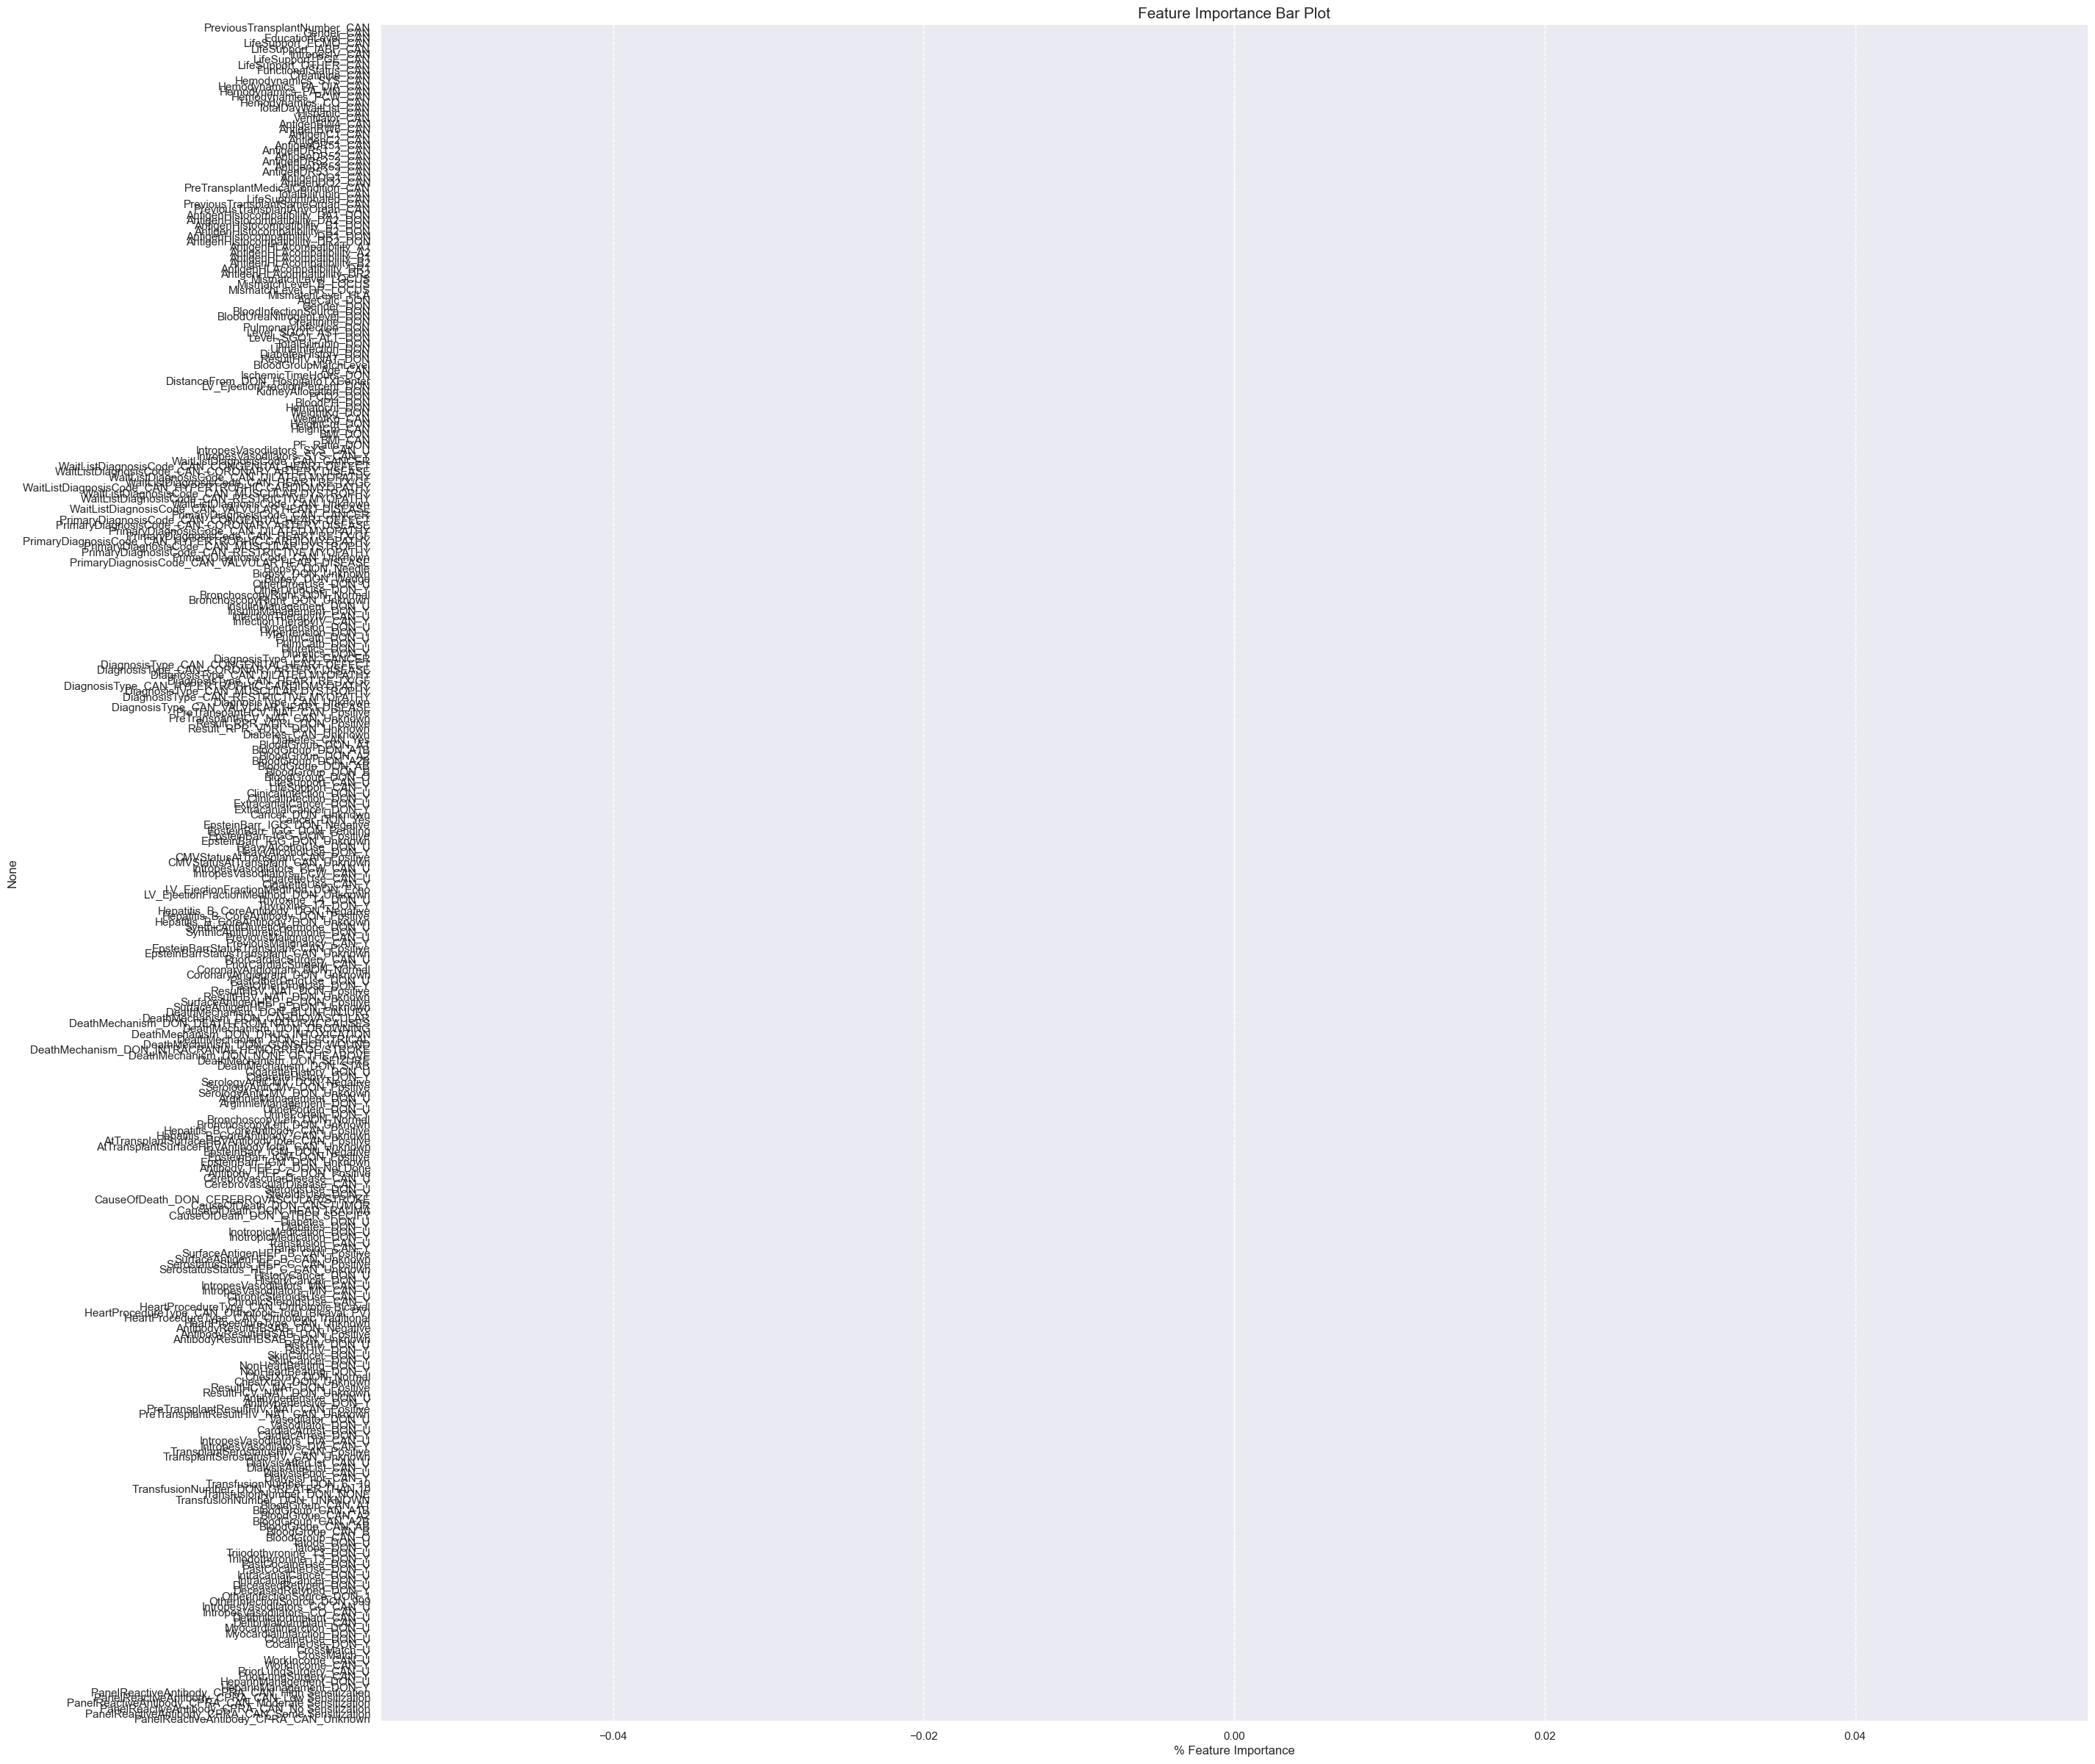

In [32]:
# plot
plotFeatureImportance(model, X_train)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7255
           1       0.13      1.00      0.23      1064

    accuracy                           0.13      8319
   macro avg       0.06      0.50      0.11      8319
weighted avg       0.02      0.13      0.03      8319



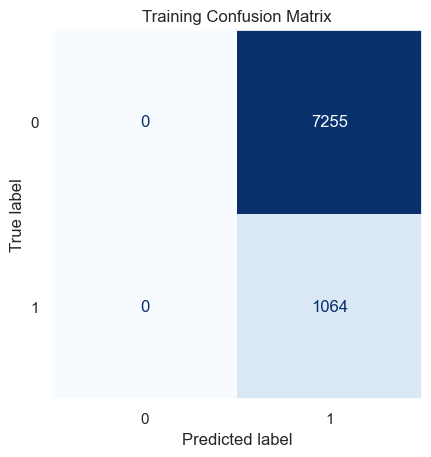

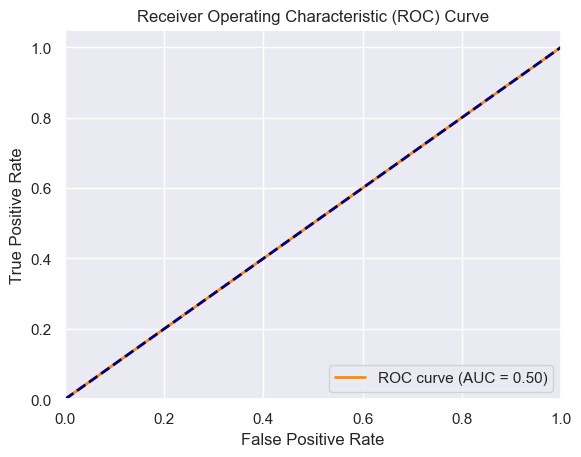

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.5,1.0,0.226793,0.1279,0.1279,0.0,0.5


In [33]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train, y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.13      1.00      0.23       266

    accuracy                           0.13      2080
   macro avg       0.06      0.50      0.11      2080
weighted avg       0.02      0.13      0.03      2080



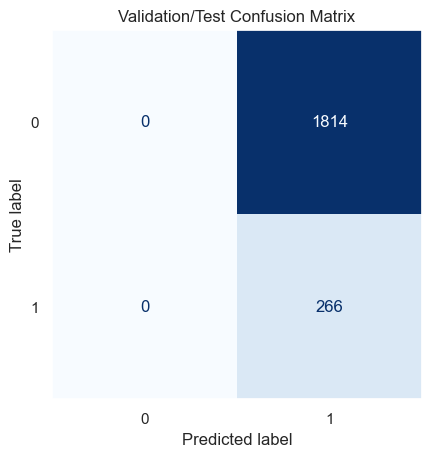

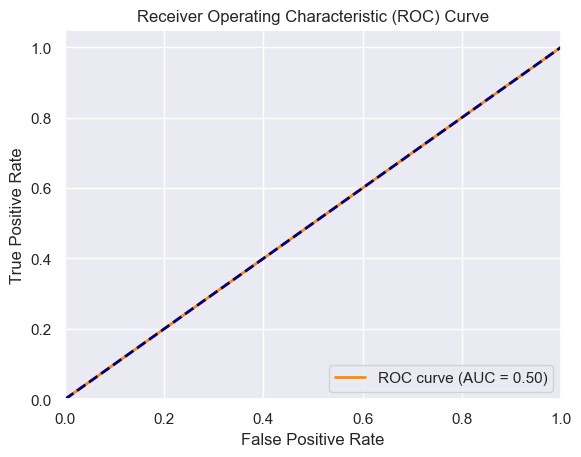

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.5,1.0,0.226793,0.127900,0.127900,0.0,0.5
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.5,1.0,0.226769,0.127885,0.127885,0.0,0.5


In [34]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val, y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### SMOTE

In [35]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - SMOTE'
Model = 'rfc_resampled_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_resampled_fit = stratified_grid(model, parameters, X_train_resampled, y_train_resampled)

# best model
model = rfc_resampled_fit.best_estimator_

CV accuracy: 0.878 +/- 0.009


                                                       % Feature Importance
PriorCardiacSurgery_CAN_Y                                          8.789299
Diabetes_CAN_Yes                                                   6.473406
CigaretteUse_CAN_Y                                                 6.459350
OtherDrugUse_DON_U                                                 5.740883
ArginnieManagement_DON_Y                                           4.119751
InotropicMedication_DON_Y                                          3.716982
InsulinManagement_DON_Y                                            3.652631
Transfusion_CAN_Y                                                  3.646547
CMVStatusAtTransplant_CAN_Positive                                 3.192103
DefibrillatorImplant_CAN_Y                                         3.191555
CocaineUse_DON_U                                                   2.819789
BloodGroup_CAN_O                                                   2.601113
Thyroxine_T4

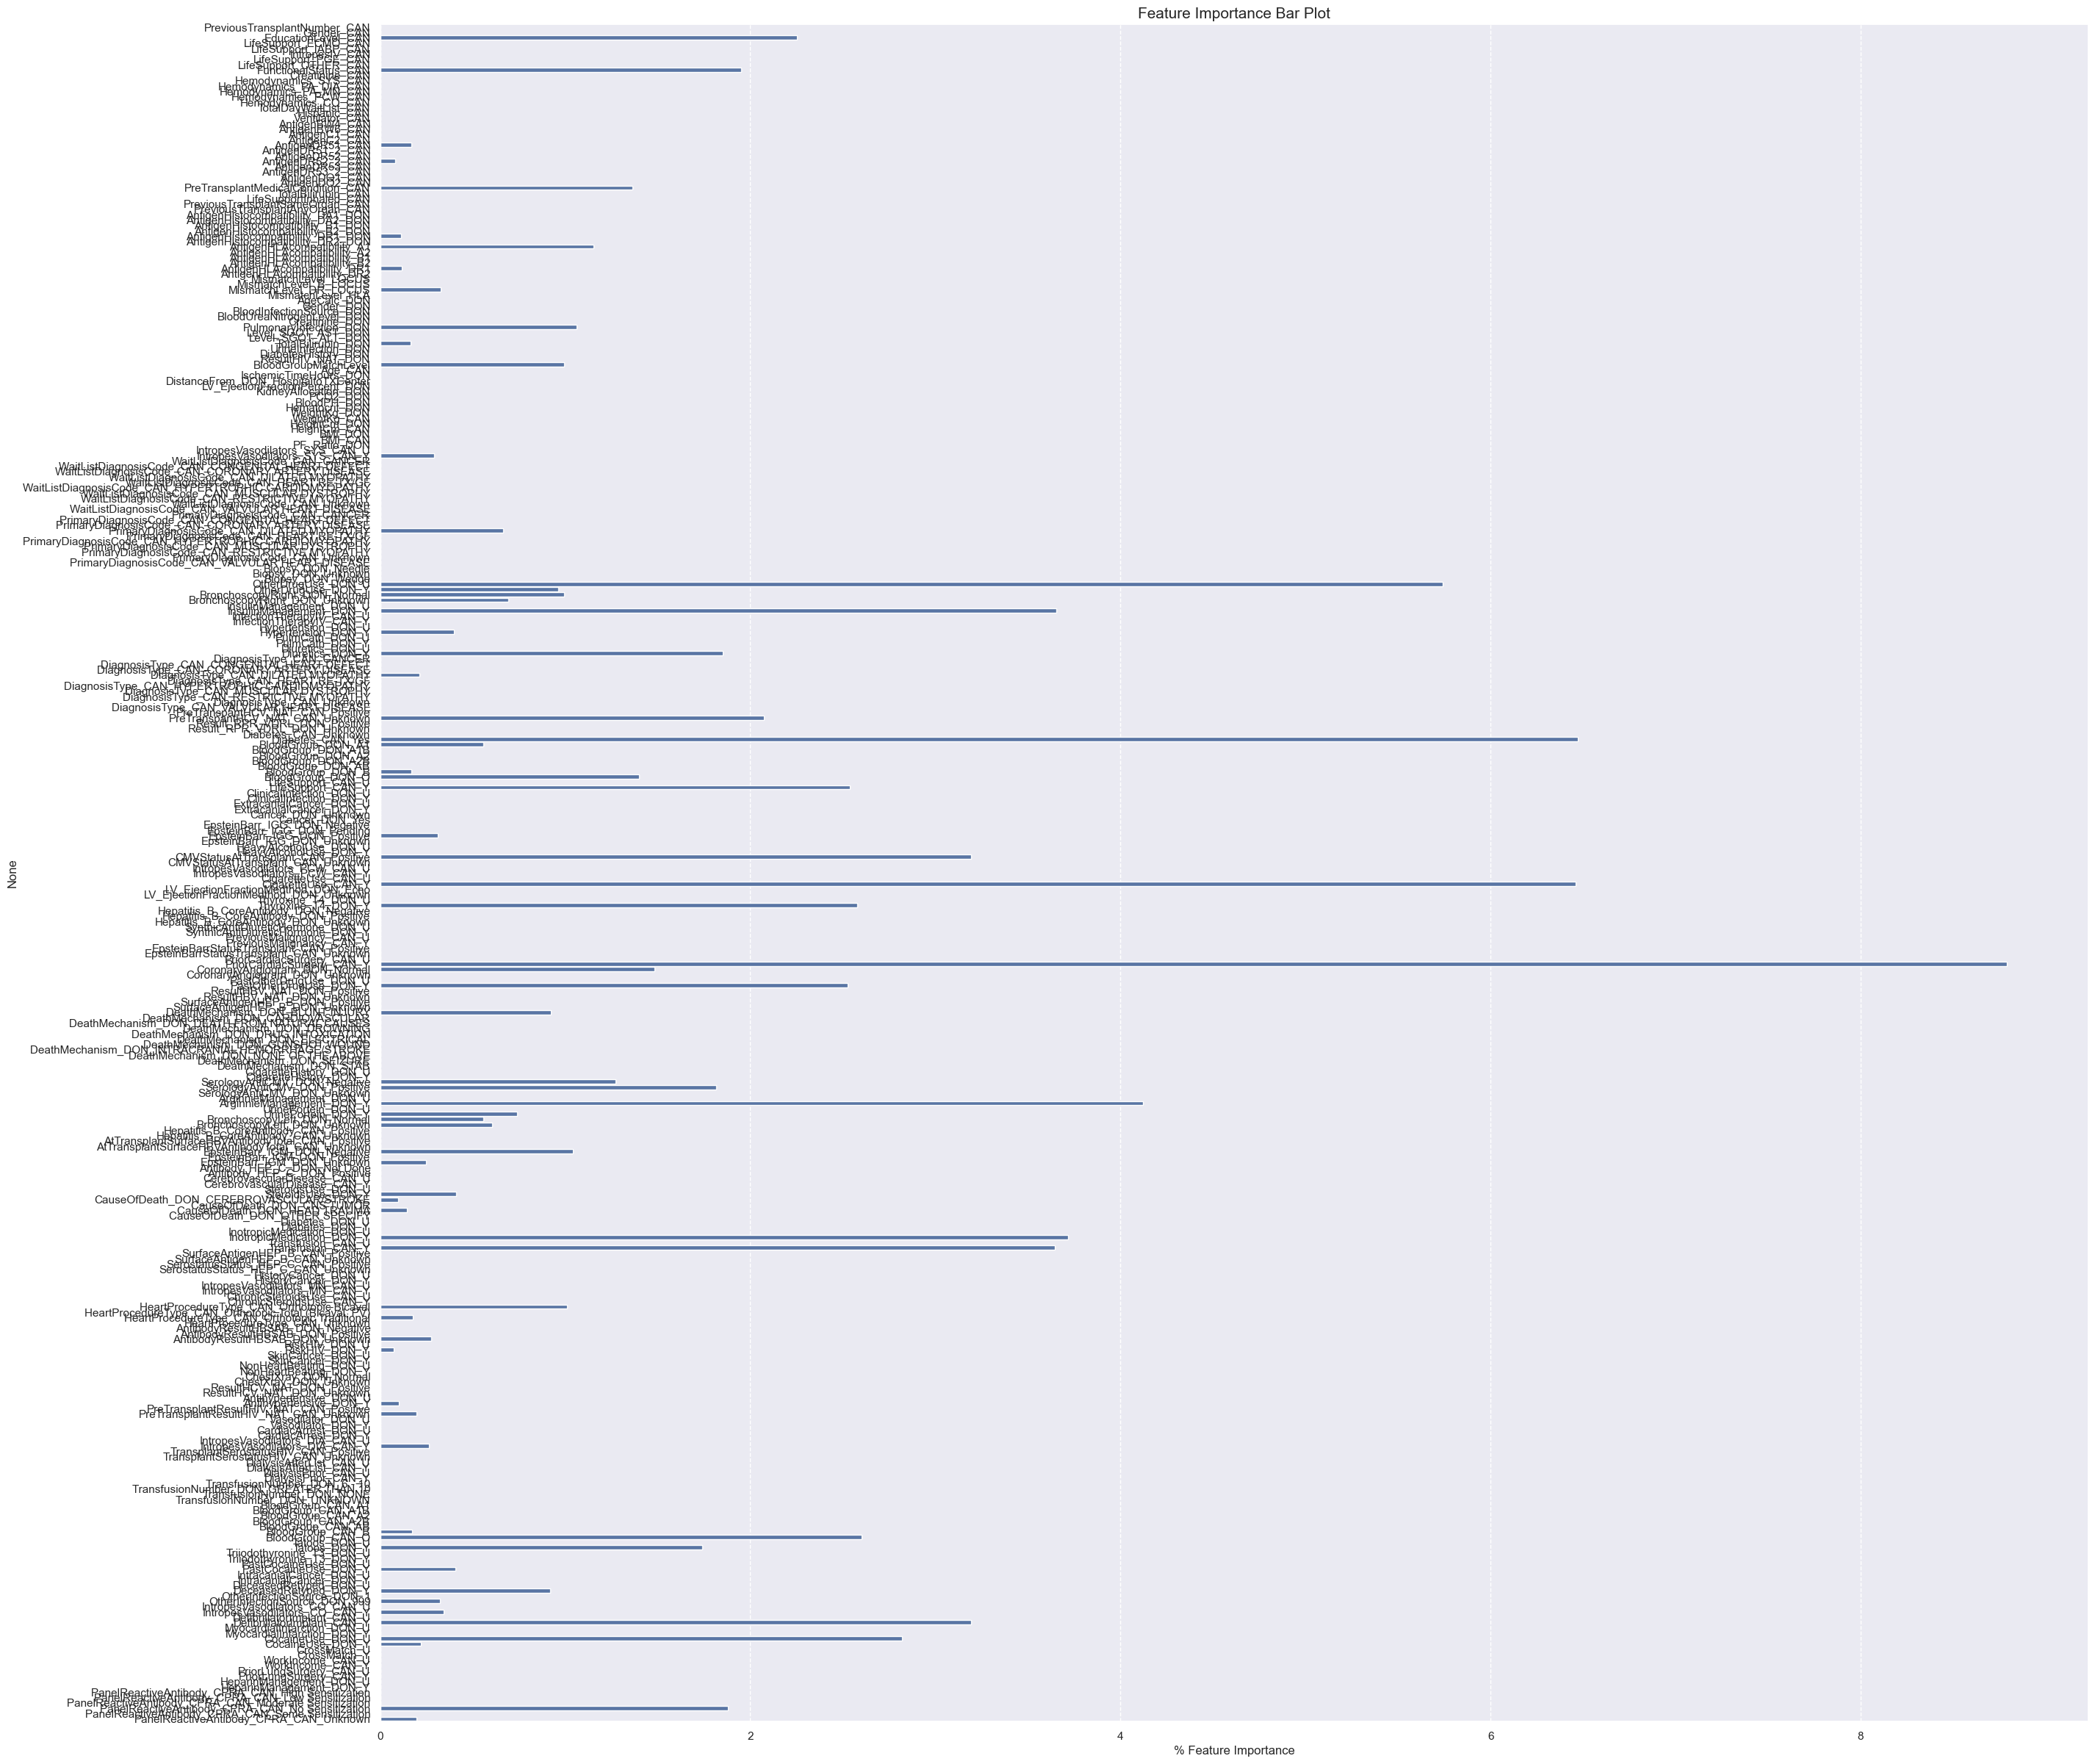

In [36]:
# plot
plotFeatureImportance(model, X_train_resampled)

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      7255
           1       0.92      0.83      0.87      7255

    accuracy                           0.88     14510
   macro avg       0.88      0.88      0.88     14510
weighted avg       0.88      0.88      0.88     14510



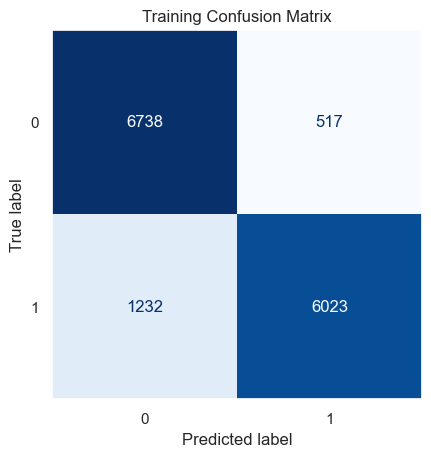

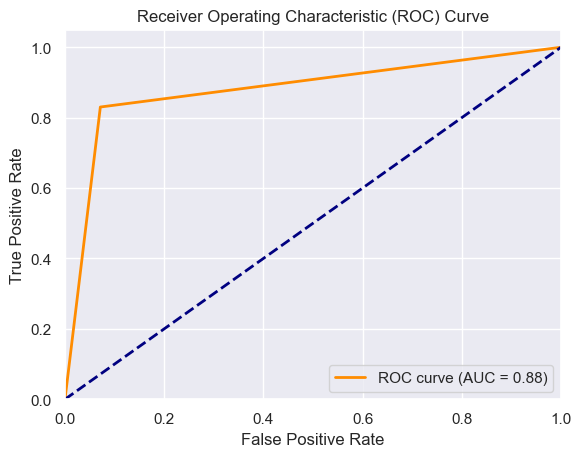

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462


In [37]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_resampled, y_train_resampled, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      1814
           1       0.12      0.07      0.09       266

    accuracy                           0.81      2080
   macro avg       0.49      0.50      0.49      2080
weighted avg       0.77      0.81      0.79      2080



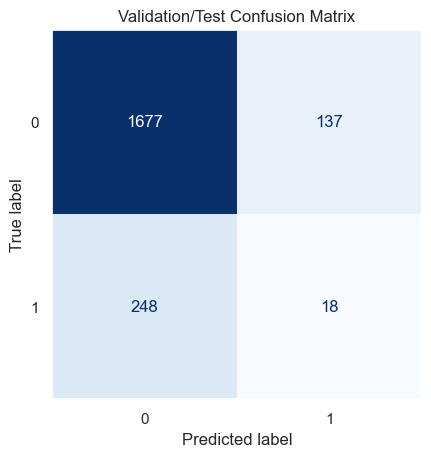

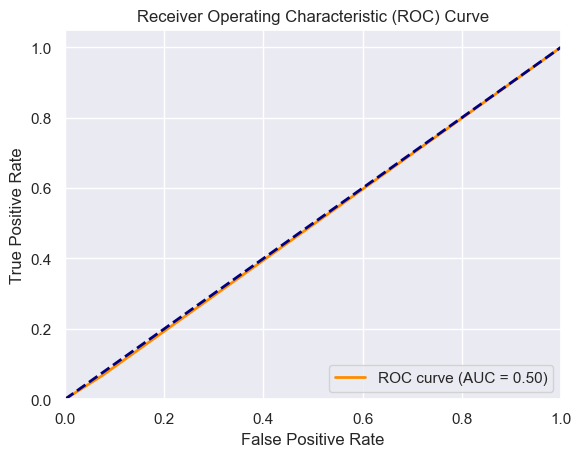

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462
3,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Validation,0.496073,0.067669,0.085511,0.127089,0.116129,0.924476,0.496073


In [38]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val, y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### FAMD

In [39]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - FAMD'
Model = 'rfc_famd_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_famd_fit = stratified_grid(model, parameters, X_train_famd, y_train)

# best model
model = rfc_famd_fit.best_estimator_

CV accuracy: 0.500 +/- 0.000


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7255
           1       0.13      1.00      0.23      1064

    accuracy                           0.13      8319
   macro avg       0.06      0.50      0.11      8319
weighted avg       0.02      0.13      0.03      8319



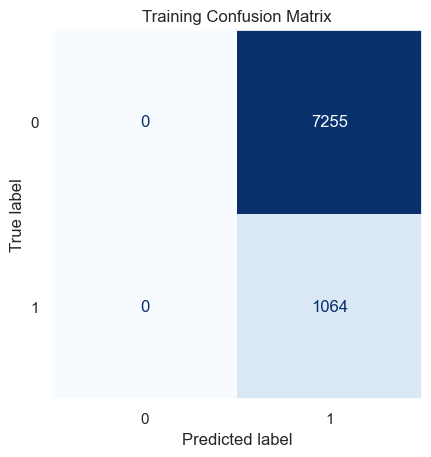

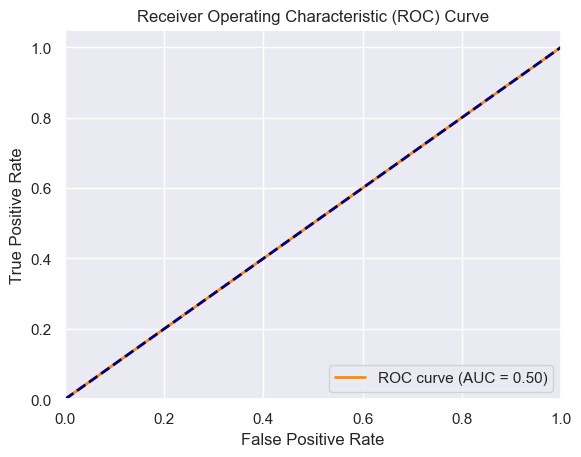

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462
3,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Validation,0.496073,0.067669,0.085511,0.127089,0.116129,0.924476,0.496073
4,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000


In [40]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_famd, y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.13      1.00      0.23       266

    accuracy                           0.13      2080
   macro avg       0.06      0.50      0.11      2080
weighted avg       0.02      0.13      0.03      2080



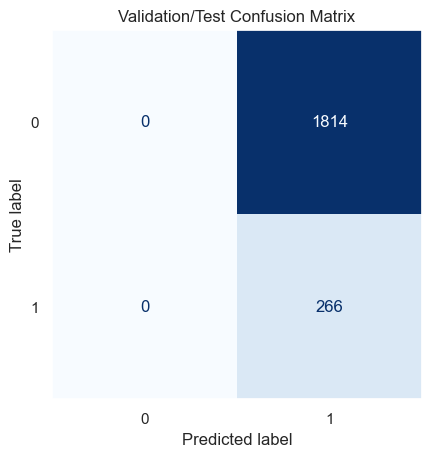

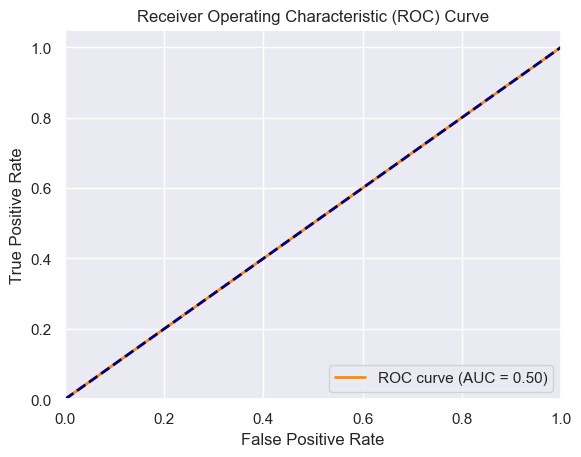

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462
3,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Validation,0.496073,0.067669,0.085511,0.127089,0.116129,0.924476,0.496073
4,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
5,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000


In [41]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_famd, y_val, flag=True)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### PCA

In [42]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - PCA'
Model = 'rfc_pca_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_pca_fit = stratified_grid(model, parameters, X_train_pca, y_train)

# best model
model = rfc_pca_fit.best_estimator_

CV accuracy: 0.500 +/- 0.000


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      7255
           1       0.13      1.00      0.23      1064

    accuracy                           0.13      8319
   macro avg       0.06      0.50      0.11      8319
weighted avg       0.02      0.13      0.03      8319



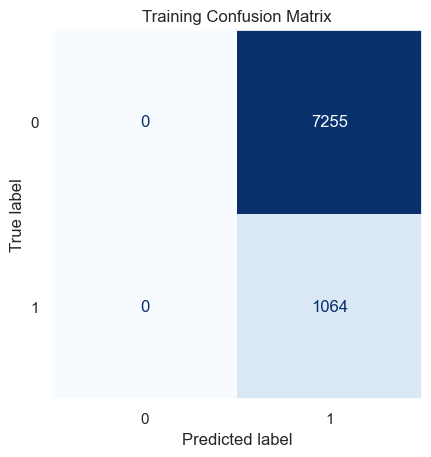

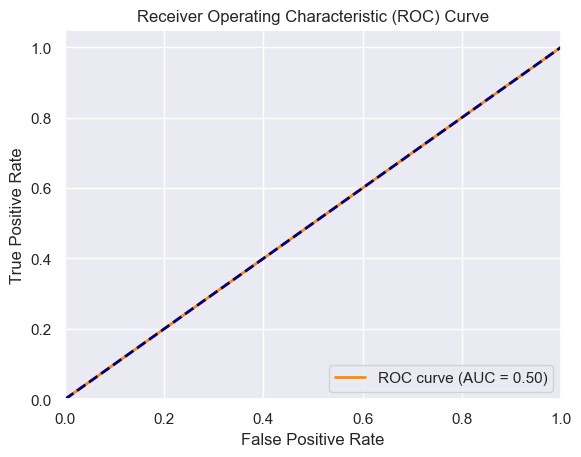

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462
3,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Validation,0.496073,0.067669,0.085511,0.127089,0.116129,0.924476,0.496073
4,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
5,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
6,RandomForestClassifier,rfc_pca_fit,RandomForestClassifier - Grid Search - PCA,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000


In [43]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_pca, y_train, flag=False)

# initialize variable
Type = 'Training'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.13      1.00      0.23       266

    accuracy                           0.13      2080
   macro avg       0.06      0.50      0.11      2080
weighted avg       0.02      0.13      0.03      2080



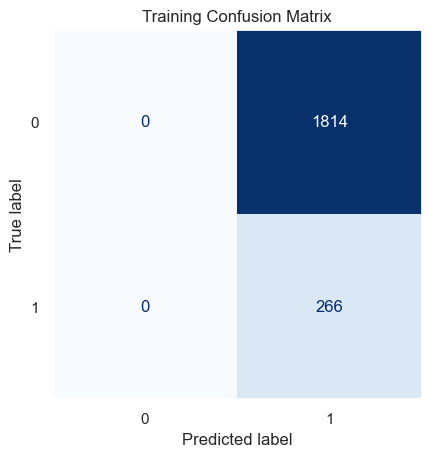

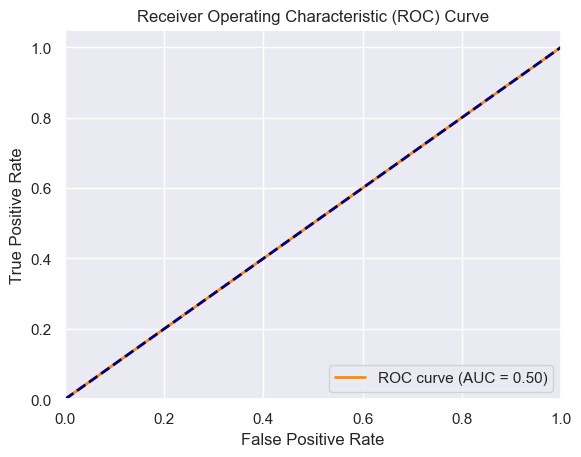

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
1,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
2,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Training,0.879462,0.830186,0.873215,0.849465,0.920948,0.928739,0.879462
3,RandomForestClassifier,rfc_resampled_fit,RandomForestClassifier - Grid Search - SMOTE,Validation,0.496073,0.067669,0.085511,0.127089,0.116129,0.924476,0.496073
4,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
5,RandomForestClassifier,rfc_famd_fit,RandomForestClassifier - Grid Search - FAMD,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000
6,RandomForestClassifier,rfc_pca_fit,RandomForestClassifier - Grid Search - PCA,Training,0.500000,1.000000,0.226793,0.127900,0.127900,0.000000,0.500000
7,RandomForestClassifier,rfc_pca_fit,RandomForestClassifier - Grid Search - PCA,Validation,0.500000,1.000000,0.226769,0.127885,0.127885,0.000000,0.500000


In [44]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_pca, y_val, flag=False)

# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication